In [1]:
import pandas as pd

# Load the CSV files
canceled_flights = pd.read_csv('canceled_flights_2022.csv')
non_cancelled_flights = pd.read_csv('non_cancelled_flights_2022.csv')
weather_data = pd.read_csv('weather_data_2022.csv')

# Define the airline codes of interest
airline_codes = {
    'DL': 'Delta',
    'AA': 'American',
    'UA': 'United'
}

# Create separate sampled files for each airline based on AIRLINE_CODE
for code, airline in airline_codes.items():
    # Filter and save data for canceled flights
    canceled_sample = canceled_flights[canceled_flights['AIRLINE_CODE'] == code]
    canceled_sample.to_csv(f'canceled_{airline.lower()}_flights.csv', index=False)
    
    # Filter and save data for non-canceled flights
    non_cancelled_sample = non_cancelled_flights[non_cancelled_flights['AIRLINE_CODE'] == code]
    non_cancelled_sample.to_csv(f'non_cancelled_{airline.lower()}_flights.csv', index=False)

print("Sampling and saving completed!")


Sampling and saving completed!


In [11]:
# Load the weather dataset
weather_data = pd.read_csv('weather_data_2022.csv')


# Remove the 'K' from the AirportCode in weather_data
weather_data['AirportCode'] = weather_data['AirportCode'].str.replace('K', '', regex=False)


In [33]:
import pandas as pd
import calendar
from datetime import datetime, timedelta

# Load the federal holidays dataset
holidays = pd.read_csv('federal_holidays.csv')

# Function to generate holiday dates
def generate_holiday_dates(year, holiday_data):
    holiday_dates = []
    
    for index, row in holiday_data.iterrows():
        holiday_name = row['official_name']
        date_definition = row['date_definition']
        date_str = row['date']
        
        # Handle fixed date holidays (e.g., "1-Jan" or "January 1")
        if 'fixed date' in date_definition.lower():
            date_str = date_str.replace('â€“', '-').strip()
            try:
                holiday_date = datetime.strptime(f"{date_str}-{year}", "%d-%b-%Y").date()
            except ValueError:
                holiday_date = datetime.strptime(f"{date_str} {year}", "%B %d %Y").date()
            holiday_dates.append(holiday_date)
        
        # Handle holidays defined by a specific week of the month (e.g., "3rd Monday")
        elif 'monday' in date_definition.lower() or 'thursday' in date_definition.lower():
            if 'â€“' in date_str:  # If there's a range, split it
                month, week = date_str.split('â€“')
                month = datetime.strptime(month.strip(), "%B").month
                week_number = int(week.split()[0])
                
                first_day_of_month = datetime(year, month, 1)
                weekday = calendar.MONDAY if 'monday' in date_definition.lower() else calendar.THURSDAY
                days_to_add = (weekday - first_day_of_month.weekday() + 7 * (week_number - 1)) % 7
                holiday_date = first_day_of_month + timedelta(days=days_to_add)
                holiday_dates.append(holiday_date)
            else:
                try:
                    holiday_date = datetime.strptime(f"{date_str} {year}", "%B %d %Y").date()
                    holiday_dates.append(holiday_date)
                except ValueError:
                    pass

    return holiday_dates

# Generate the list of federal holiday dates for 2022
holiday_dates_2022 = generate_holiday_dates(2022, holidays)

# Convert to DataFrame
holiday_df = pd.DataFrame({'HolidayDate': holiday_dates_2022})

# Load the weather data (adjust the file path as needed)
weather_data = pd.read_csv('weather_data_2022.csv')

# Remove 'K' prefix from the AirportCode in the weather data
weather_data['AirportCode'] = weather_data['AirportCode'].str.lstrip('K')

# Convert StartTime to datetime and extract just the date part
weather_data['StartTime(UTC)'] = pd.to_datetime(weather_data['StartTime(UTC)']).dt.date

# Merge weather data with holiday information
weather_data['Holiday'] = weather_data['StartTime(UTC)'].isin(holiday_df['HolidayDate']).astype(int)

# Check merged weather data (optional)
print(weather_data[['StartTime(UTC)', 'Holiday', 'Precipitation(in)', 'Severity']].head())

# List of flight dataset files
flight_files = [
    'canceled_delta_flights.csv',
    'canceled_american_flights.csv',
    'canceled_united_flights.csv',
    'non_cancelled_delta_flights.csv',
    'non_cancelled_american_flights.csv',
    'non_cancelled_united_flights.csv'
]

# Process each flight dataset and merge with the weather data (now containing holiday info)
for flight_file in flight_files:
    # Load flight data
    flight_data = pd.read_csv(flight_file)
    
    # Convert 'FL_DATE' to datetime and extract just the date part for merging
    flight_data['FL_DATE'] = pd.to_datetime(flight_data['FL_DATE']).dt.date
    
    # Merge weather data for ORIGIN airport
    weather_origin = weather_data.rename(columns={'Precipitation(in)': 'Precipitation(in)_origin', 
                                                  'Severity': 'Severity_origin', 
                                                  'Holiday': 'Holiday_origin'})
    merged_data_origin = pd.merge(flight_data, weather_origin, 
                                  left_on=['ORIGIN', 'FL_DATE'], 
                                  right_on=['AirportCode', 'StartTime(UTC)'], 
                                  how='left')
    
    # Merge weather data for DEST airport
    weather_dest = weather_data.rename(columns={'Precipitation(in)': 'Precipitation(in)_dest', 
                                                'Severity': 'Severity_dest', 
                                                'Holiday': 'Holiday_dest'})
    merged_data_dest = pd.merge(merged_data_origin, weather_dest, 
                                 left_on=['DEST', 'FL_DATE'], 
                                 right_on=['AirportCode', 'StartTime(UTC)'], 
                                 how='left')
    
    # Check merged data (optional)
    print(f"Data with weather and holiday info for {flight_file}:")
    print(merged_data_dest[['FL_DATE', 'ORIGIN', 'DEST', 'Holiday_origin', 'Holiday_dest', 
                            'Precipitation(in)_origin', 'Precipitation(in)_dest']].head())
    
    # Save the merged data into a new file (optional)
    merged_filename = f"merged_weather_holiday_{flight_file}"
    merged_data_dest.to_csv(merged_filename, index=False)


  StartTime(UTC)  Holiday  Precipitation(in) Severity
0     2022-01-01        1                0.0    Light
1     2022-01-01        1                0.0    Light
2     2022-01-06        0                0.0   Severe
3     2022-01-08        0                0.0    Light
4     2022-01-21        0                0.0    Light
Data with weather and holiday info for canceled_delta_flights.csv:
      FL_DATE ORIGIN DEST  Holiday_origin  Holiday_dest  \
0  2022-06-19    SEA  ANC             1.0           NaN   
1  2022-05-30    MSY  LAX             NaN           NaN   
2  2022-07-01    ATL  BUF             0.0           0.0   
3  2022-07-01    ATL  BUF             0.0           0.0   
4  2022-07-01    ATL  BUF             0.0           0.0   

   Precipitation(in)_origin  Precipitation(in)_dest  
0                      0.00                     NaN  
1                       NaN                     NaN  
2                      0.01                    0.00  
3                      0.01           

C:\Users\goderisd\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\goderisd\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\goderisd\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\goderisd\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Ind

RMSE: 53.93


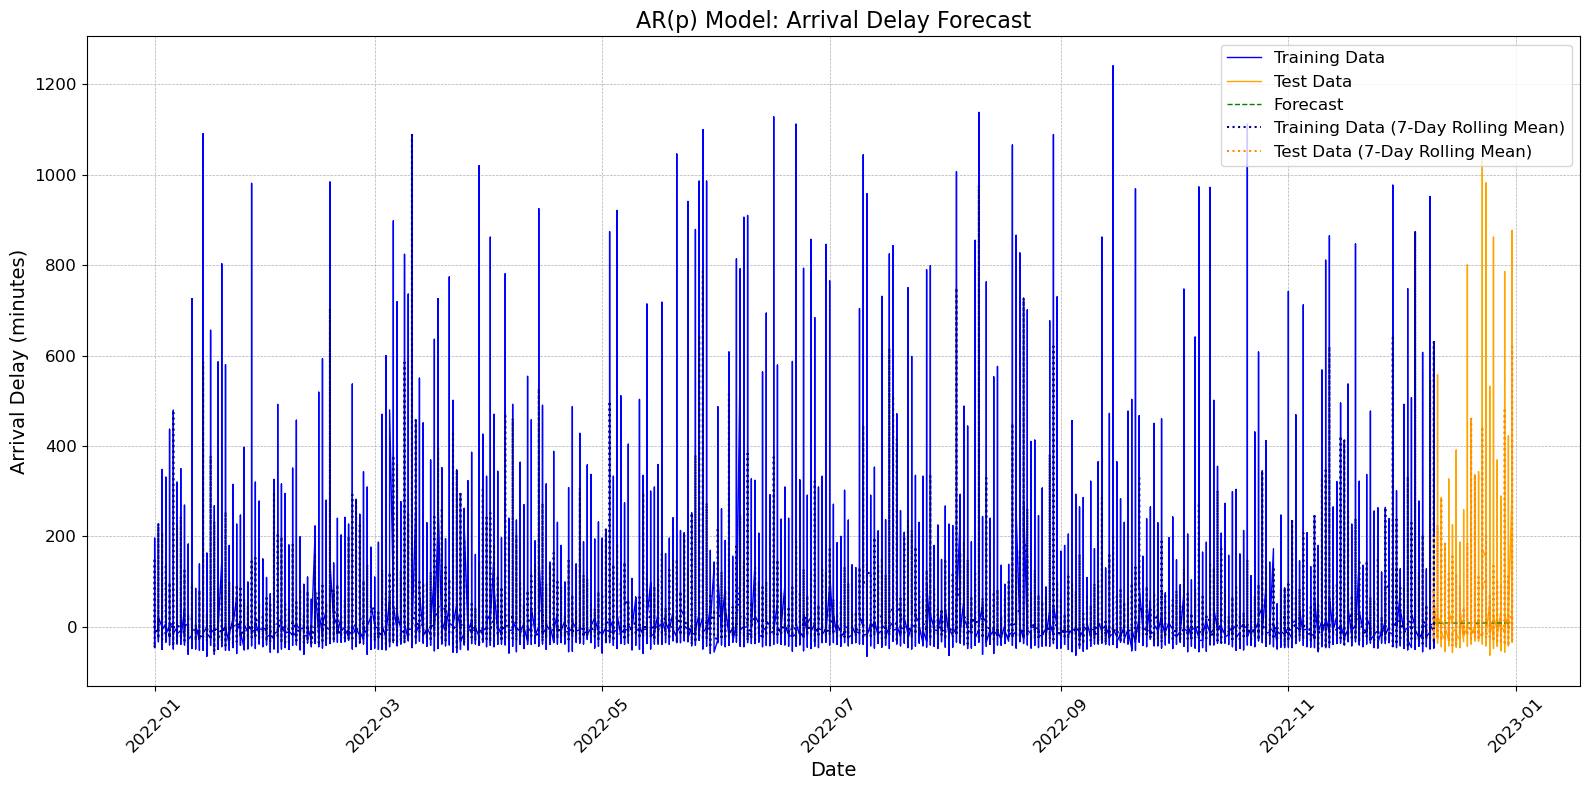

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load Delta Airlines data
def load_delta_data():
    base_path = os.path.dirname(__file__)
    non_cancelled_path = os.path.join(base_path, 'merged_weather_holiday_non_cancelled_delta_flights.csv')
    non_cancelled_data = pd.read_csv(non_cancelled_path, parse_dates=['FL_DATE'])
    return non_cancelled_data

# Prepare Data
df = non_cancelled_data[['FL_DATE', 'ARR_DELAY']].dropna()
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
df = df.sort_values('FL_DATE')

# Set time index
df.set_index('FL_DATE', inplace=True)

# Use ARR_DELAY as the target variable
arr_delay = df['ARR_DELAY']

# Split into train and test sets (e.g., last 12 months as test)
train_size = int(len(arr_delay) * 0.9)
train, test = arr_delay[:train_size], arr_delay[train_size:]

# Fit AR(p) model
p = 4  # Lag order (can be optimized)
ar_model = AutoReg(train, lags=p).fit()

# Forecast
forecast = ar_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Evaluate
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE: {rmse:.2f}")

# Plot Results

plt.figure(figsize=(16, 8))

# Plot Training Data
plt.plot(train.index, train, label='Training Data', color='blue', linewidth=1)

# Plot Test Data
plt.plot(test.index, test, label='Test Data', color='orange', linewidth=1)

# Plot Forecast
plt.plot(test.index, forecast, label='Forecast', linestyle='--', color='green', linewidth=1)

# Overlay Rolling Means
plt.plot(train.index, train.rolling(window=7).mean(), label='Training Data (7-Day Rolling Mean)', color='darkblue', linestyle=':')
plt.plot(test.index, test.rolling(window=7).mean(), label='Test Data (7-Day Rolling Mean)', color='darkorange', linestyle=':')

# Add Titles and Labels
plt.title("AR(p) Model: Arrival Delay Forecast", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Arrival Delay (minutes)", fontsize=14)

# Format Ticks
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Add Grid, Legend, and Show Plot
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pandas as pd
import streamlit as st

def load_and_prepare_data(airline,
                          features=['ARR_DELAY', 'DEP_DELAY', 'Precipitation(in)_origin', 'Precipitation(in)_dest',
                                    'Holiday_origin']):
    non_cancelled_data, cancelled_data = load_airline_data(airline)

    # Select relevant columns for VAR model
    df = non_cancelled_data[['FL_DATE'] + features]

    # Set the date column as the index
    df = df.set_index('FL_DATE')

    # Fill missing values using forward fill
    df = df.fillna(method='ffill')

    # Check stationarity (ADF test)
    adf_test = adfuller(df['ARR_DELAY'])
    st.write(f'ADF Test Statistic: {adf_test[0]}')
    st.write(f'p-value: {adf_test[1]}')

# Function to prepare and train a Random Forest model
def fit_random_forest(df, target_column, features, forecast_steps):
    # Train-test split
    X = df[features]
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Train the model with optimizations
    model = RandomForestRegressor(n_estimators=5, max_depth=10, max_features=0.5, n_jobs=-1, random_state=42)
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Forecasting for next `forecast_steps` days (simple extension of model output)
    forecast = model.predict(X.tail(forecast_steps))

    # Return forecast and evaluation metrics
    return forecast, y_pred, y_test

# Load and prepare data for Random Forest model
features = ['DEP_DELAY', 'Precipitation(in)_origin', 'Precipitation(in)_dest', 'Holiday_origin']
target_column = 'ARR_DELAY'

df = load_and_prepare_data('Delta', features + [target_column])

# Fit and forecast with the Random Forest model
forecast, y_pred, y_test = fit_random_forest(df, target_column, features, forecast_steps)

C:\Users\goderisd\AppData\Local\Temp\ipykernel_21876\918089931.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


KeyboardInterrupt: 

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pandas as pd

def load_and_prepare_data(airline,
                          features=['ARR_DELAY', 'DEP_DELAY', 'Precipitation(in)_origin', 'Precipitation(in)_dest',
                                    'Holiday_origin']):
    non_cancelled_data, cancelled_data = load_airline_data(airline)

    # Select relevant columns for model
    df = non_cancelled_data[['FL_DATE'] + features]

    # Set the date column as the index
    df = df.set_index('FL_DATE')

    # Fill missing values using forward fill
    df = df.fillna(method='ffill')

    # Downsample the dataset to 10%
    df = df.sample(frac=0.1, random_state=42)

    # Check stationarity (ADF test)
    adf_test = adfuller(df['ARR_DELAY'])
    st.write(f'ADF Test Statistic: {adf_test[0]}')
    st.write(f'p-value: {adf_test[1]}')

    return df

def fit_random_forest(df, target_column, features, forecast_steps):
    # Train-test split
    X = df[features]
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Train the model with optimizations
    model = RandomForestRegressor(n_estimators=5, max_depth=10, max_features=0.5, n_jobs=-1, random_state=42)
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Forecasting for next `forecast_steps` days (simple extension of model output)
    forecast = model.predict(X.tail(forecast_steps))

    # Return forecast and evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    return forecast, y_pred, y_test, mse

# Define the features and target column for the Random Forest model
features = ['DEP_DELAY', 'Precipitation(in)_origin', 'Precipitation(in)_dest', 'Holiday_origin']
target_column = 'ARR_DELAY'

# Load and prepare the data for Random Forest model
df = load_and_prepare_data('Delta', features + [target_column])

# Fit and forecast with the Random Forest model
forecast_steps = 10  # Specify the number of forecast steps
forecast, y_pred, y_test, mse = fit_random_forest(df, target_column, features, forecast_steps)

# Display the results
st.write(f"Forecast for the next {forecast_steps} days:")
st.write(forecast)
st.write(f"Mean Squared Error: {mse:.2f}")

C:\Users\goderisd\AppData\Local\Temp\ipykernel_21876\2517361771.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
